## 240 Project: Cloud Patterns Detection



In [0]:
import os
import gc
import cv2
import time
import tqdm
import random
import collections
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt
from tqdm.auto import tqdm as tq
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import albumentations as albu
# from albumentations import torch as AT
plt.style.use('bmh')

## Data Reviewing

In [0]:
path = "../input/understanding_cloud_organization"
img_paths = "../input/understanding-clouds-resized"
train_on_gpu = torch.cuda.is_available()
n_train = len(os.listdir(f'{path}/train_images'))
n_test = len(os.listdir(f'{path}/test_images'))
print(f'There are {n_train} images in train dataset')
print(f'There are {n_test} images in test dataset')

There are 5546 images in train dataset
There are 3698 images in test dataset


In [0]:
train = pd.read_csv(f'{path}/train.csv')
test = pd.read_csv(f'{path}/sample_submission.csv')
train_new = pd.DataFrame()
train_new['img'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
train_new['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
train_new['EncodedPixels'] = train['EncodedPixels']
test_new = pd.DataFrame()
test_new['img'] = test['Image_Label'].apply(lambda x: x.split('_')[0])
test_new['label'] = test['Image_Label'].apply(lambda x: x.split('_')[1])
test_new['EncodedPixels'] = test['EncodedPixels']
train_new.head(n=8)


,img,label,EncodedPixels
0,0011165.jpg,Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg,Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg,Gravel,NaN
3,0011165.jpg,Sugar,NaN
4,002be4f.jpg,Fish,233813 878 235213 878 236613 878 238010 881 23...
5,002be4f.jpg,Flower,1339279 519 1340679 519 1342079 519 1343479 51...
6,002be4f.jpg,Gravel,NaN
7,002be4f.jpg,Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...


In [0]:
train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[1]).value_counts()

Sugar     3751
Gravel    2939
Fish      2781
Flower    2365
Name: Image_Label, dtype: int64

In [0]:
train_new = pd.DataFrame()
train_new['img'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
train_new['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
train_new['EncodedPixels'] = train['EncodedPixels']
test_new = pd.DataFrame()
test_new['img'] = test['Image_Label'].apply(lambda x: x.split('_')[0])
test_new['label'] = test['Image_Label'].apply(lambda x: x.split('_')[1])
test_new['EncodedPixels'] = test['EncodedPixels']

def detect(train_new, img):
    image = plt.imread(f"{path}/train_images/" + img)
    rle_string = train_new[(train_new['img']==img)]['EncodedPixels'].iloc[0]
    rle_numbers = [int(num_string) for num_string in rle_string.split(' ')]
    rle_pairs = np.array(rle_numbers).reshape(-1,2)  # reshape to nx2
    img = np.zeros(1400*2100, dtype=np.uint8)
    for index, length in rle_pairs:
        index -= 1
        img[index:index+length] = 100
    img = img.reshape(2100,1400) 
    np_mask = img.T
    np_mask = np.clip(np_mask, 0, 1)
    return np_mask

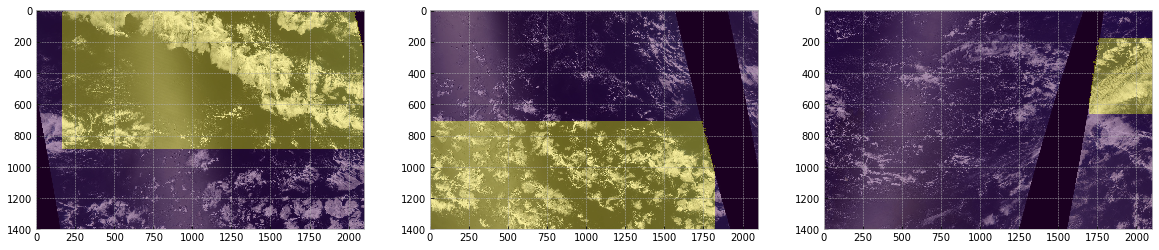

In [0]:
fig = plt.figure(figsize=(20,25))
data_vis = train_new[train_new['label']=='Fish'].dropna()
for i in range(1,4):
    fig.add_subplot(4,3,i)
    mask = detect(data_vis , data_vis.iloc[i]['img'])
    image = plt.imread(f"{path}/train_images/" + data_vis.iloc[i]['img'])
    plt.imshow(image);
    plt.imshow(mask, alpha=0.4);

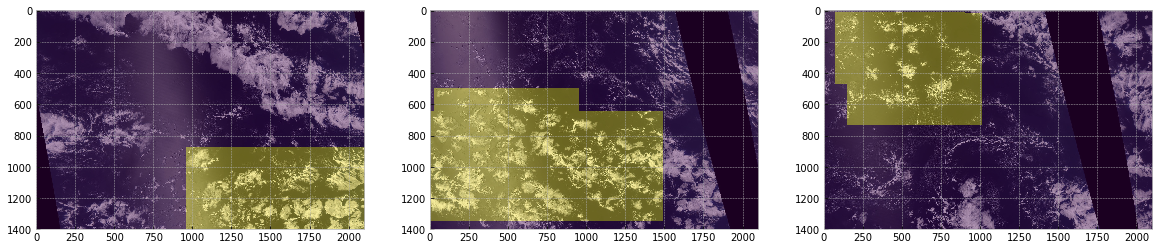

In [0]:
fig = plt.figure(figsize=(20,25))
data_vis = train_new[train_new['label']=='Flower'].dropna()
for i in range(1,4):
    fig.add_subplot(4,3,i)
    mask = detect(data_vis , data_vis.iloc[i]['img'])
    image = plt.imread(f"{path}/train_images/" + data_vis.iloc[i]['img'])
    plt.imshow(image);
    plt.imshow(mask, alpha=0.4);

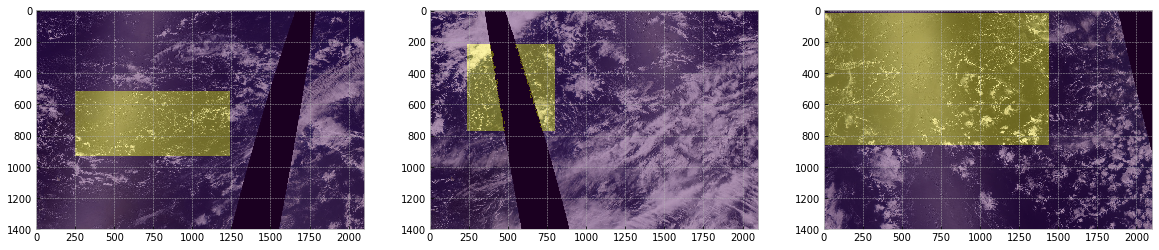

In [0]:
fig = plt.figure(figsize=(20,25))
data_vis = train_new[train_new['label']=='Gravel'].dropna()
for i in range(1,4):
    fig.add_subplot(4,3,i)
    mask = detect(data_vis , data_vis.iloc[i]['img'])
    image = plt.imread(f"{path}/train_images/" + data_vis.iloc[i]['img'])
    plt.imshow(image);
    plt.imshow(mask, alpha=0.4);

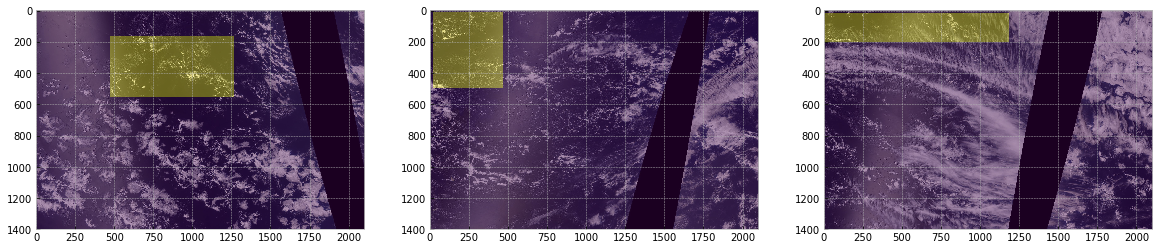

In [0]:
fig = plt.figure(figsize=(20,25))
data_vis = train_new[train_new['label']=='Sugar'].dropna()
for i in range(1,4):
    fig.add_subplot(4,3,i)
    mask = detect(data_vis , data_vis.iloc[i]['img'])
    image = plt.imread(f"{path}/train_images/" + data_vis.iloc[i]['img'])
    plt.imshow(image);
    plt.imshow(mask, alpha=0.4);

## DataLoader

In [0]:
class CloudDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame = None,
        datatype: str = "train",
        img_ids: np.array = None,
        transforms=albu.Compose([albu.HorizontalFlip()]), #, AT.ToTensor()
    ):
        self.df = df
        if datatype != "test":
            self.data_folder = f"{img_paths}/train_images_525/train_images_525"
        else:
            self.data_folder = f"{img_paths}/test_images_525/test_images_525"
        self.img_ids = img_ids
        self.transforms = transforms

    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        mask = make_mask(self.df, image_name)
        image_path = os.path.join(self.data_folder, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        augmented = self.transforms(image=img, mask=mask)
        img = np.transpose(augmented["image"], [2, 0, 1])
        mask = np.transpose(augmented["mask"], [2, 0, 1])
        return img, mask

    def __len__(self):
        return len(self.img_ids)

## Helper Functions

In [0]:
#reference https://www.kaggle.com/dhananjay3/image-segmentation-from-scratch-in-pytorch

class_names = ['Fish', 'Flower', 'Sugar', 'Gravel']

def draw_convex_hull(mask, mode='convex'):
    
    img = np.zeros(mask.shape)
    contours, hier = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        if mode=='rect': # simple rectangle
            x, y, w, h = cv2.boundingRect(c)
            cv2.rectangle(img, (x, y), (x+w, y+h), (255, 255, 255), -1)
        if mode=='convex': # minimum convex hull
            hull = cv2.convexHull(c)
            cv2.drawContours(img, [hull], 0, (255, 255, 255),-1)
        else: # minimum area rectangle
            rect = cv2.minAreaRect(c)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            cv2.drawContours(img, [box], 0, (255, 255, 255),-1)
    return img/255.

def get_img(x, folder: str = "train_images_525/train_images_525"):
    
    data_folder = f"{img_paths}/{folder}"
    image_path = os.path.join(data_folder, x)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def rle_decode(mask_rle: str = "", shape: tuple = (1400, 2100)):
    """
    Decode rle encoded mask.

    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order="F")


def make_mask(df: pd.DataFrame, image_name: str = "img.jpg", shape: tuple = (350, 525)):
    """
    Create mask based on df, image name and shape.
    """
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)
    df = df[df["im_id"] == image_name]
    for idx, im_name in enumerate(df["im_id"].values):
        for classidx, classid in enumerate(["Fish", "Flower", "Gravel", "Sugar"]):
            mask = cv2.imread(
                "../input/understanding-clouds-resized/train_masks_525/train_masks_525/"
                + classid
                + im_name
            )
            if mask is None:
                continue
            if mask[:, :, 0].shape != (350, 525):
                mask = cv2.resize(mask, (525, 350))
            masks[:, :, classidx] = mask[:, :, 0]
    masks = masks / 255
    return masks


def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype("float32")


def mask2rle(img):
    """
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    """
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(str(x) for x in runs)


def visualize(image, mask, original_image=None, original_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: "Fish", 1: "Flower", 2: "Gravel", 3: "Sugar"}

    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 5, figsize=(24, 24))

        ax[0].imshow(image)
        for i in range(4):
            ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].set_title(f"Mask {class_dict[i]}", fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 5, figsize=(24, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title("Original image", fontsize=fontsize)

        for i in range(4):
            ax[0, i + 1].imshow(original_mask[:, :, i])
            ax[0, i + 1].set_title(f"Original mask {class_dict[i]}", fontsize=fontsize)

        ax[1, 0].imshow(image)
        ax[1, 0].set_title("Transformed image", fontsize=fontsize)

        for i in range(4):
            ax[1, i + 1].imshow(mask[:, :, i])
            ax[1, i + 1].set_title(
                f"Transformed mask {class_dict[i]}", fontsize=fontsize
            )


def visualize_with_raw(
    image, mask, original_image=None, original_mask=None, raw_image=None, raw_mask=None
):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: "Fish", 1: "Flower", 2: "Gravel", 3: "Sugar"}

    f, ax = plt.subplots(3, 5, figsize=(24, 12))

    ax[0, 0].imshow(original_image)
    ax[0, 0].set_title("Original image", fontsize=fontsize)

    for i in range(4):
        ax[0, i + 1].imshow(original_mask[:, :, i])
        ax[0, i + 1].set_title(f"Original mask {class_dict[i]}", fontsize=fontsize)

    ax[1, 0].imshow(raw_image)
    ax[1, 0].set_title("Original image", fontsize=fontsize)

    for i in range(4):
        ax[1, i + 1].imshow(raw_mask[:, :, i])
        ax[1, i + 1].set_title(f"Raw predicted mask {class_dict[i]}", fontsize=fontsize)

    ax[2, 0].imshow(image)
    ax[2, 0].set_title("Transformed image", fontsize=fontsize)

    for i in range(4):
        ax[2, i + 1].imshow(mask[:, :, i])
        ax[2, i + 1].set_title(
            f"Predicted mask with processing {class_dict[i]}", fontsize=fontsize
        )


def plot_with_augmentation(image, mask, augment):

    augmented = augment(image=image, mask=mask)
    image_flipped = augmented["image"]
    mask_flipped = augmented["mask"]
    visualize(image_flipped, mask_flipped, original_image=image, original_mask=mask)


# sigmoid = lambda x: 1 / (1 + np.exp(-x))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))



def post_process(probability, threshold, min_size):
    mask = (cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1])
    mask = draw_convex_hull(mask.astype(np.uint8))
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((350, 525), np.float32)
    num = 0
    for c in range(1, num_component):
        p = component == c
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(
            scale_limit=0.5,
            rotate_limit=0,
            shift_limit=0.1,
            p=0.5,
            border_mode=0
        ),
        albu.GridDistortion(p=0.5),
        albu.Resize(320, 640),
        albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
        albu.Resize(320, 640),
        albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
    return albu.Compose(test_transform)


def get_preprocessing(preprocessing_fn):

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


def dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)

    intersection = np.logical_and(img1, img2)

    return 2.0 * intersection.sum() / (img1.sum() + img2.sum())

def dice_no_threshold(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    eps: float = 1e-7,
    threshold: float = None,
):
   
    if threshold is not None:
        outputs = (outputs > threshold).float()

    intersection = torch.sum(targets * outputs)
    union = torch.sum(targets) + torch.sum(outputs)
    dice = 2 * intersection / (union + eps)

    return dice


def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def resize_it(x):
    if x.shape != (350, 525):
        x = cv2.resize(x, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
    return x

In [0]:
SEED = 40
MODEL_NO = 0 # in K-fold
N_FOLDS = 6 # in K-fold
seed_everything(SEED)
train = pd.read_csv(f"{path}/train.csv")
train["label"] = train["Image_Label"].apply(lambda x: x.split("_")[1])
train["im_id"] = train["Image_Label"].apply(lambda x: x.split("_")[0])

sub = pd.read_csv(f"{path}/sample_submission.csv")
sub["label"] = sub["Image_Label"].apply(lambda x: x.split("_")[1])
sub["im_id"] = sub["Image_Label"].apply(lambda x: x.split("_")[0])

# split data
id_mask_count = (
    train.loc[train["EncodedPixels"].isnull() == False, "Image_Label"]
    .apply(lambda x: x.split("_")[0])
    .value_counts()
    .sort_index()
    .reset_index()
    .rename(columns={"index": "img_id", "Image_Label": "count"})
)
ids = id_mask_count["img_id"].values
li = [
    [train_index, test_index]
    for train_index, test_index in StratifiedKFold(
        n_splits=N_FOLDS, random_state=SEED
    ).split(ids, id_mask_count["count"])
]
train_ids, valid_ids = ids[li[MODEL_NO][0]], ids[li[MODEL_NO][1]]
test_ids = sub["Image_Label"].apply(lambda x: x.split("_")[0]).drop_duplicates().values



/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [0]:

train_dataset = CloudDataset( df=train, datatype="train",img_ids=train_ids,transforms=get_training_augmentation())
valid_dataset = CloudDataset(df=train,datatype="valid",img_ids=valid_ids,transforms=get_validation_augmentation())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)

## UNet Model (because this model is suitable for satellite images)

In [0]:
class double_conv(nn.Module):

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 16)    # because of the GPU memory limit of kaggle, we can not increase the 
        self.down1 = down(16, 32)            # size of the channels
        self.down2 = down(32, 64)
        self.down3 = down(64, 128)
        self.down4 = down(128, 128)
        self.up4 = up(256, 64, False)
        self.up3 = up(128, 32, False)
        self.up2 = up(64, 16, False)
        self.up1 = up(32, 16, False)
        self.outc = outconv(16, n_classes)
#         self.down1 = down(16, 32)
#         self.down2 = down(32, 64)
#         self.down3 = down(64, 128)
#         self.down4 = down(128, 256)
#         self.down5 = down(256, 256)
#         self.up5 = up(512, 128, False)
#         self.up4 = up(256, 64, False)
#         self.up3 = up(128, 32, False)
#         self.up2 = up(64, 16, False)
#         self.up1 = up(32, 16, False)
#         self.outc = outconv(16, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up4(x5, x4)
        x = self.up3(x, x3)
        x = self.up2(x, x2)
        x = self.up1(x, x1)
#         x1 = self.inc(x)
#         x2 = self.down1(x1)
#         x3 = self.down2(x2)
#         x4 = self.down3(x3)
#         x5 = self.down4(x4)
#         x6 = self.down5(x5)
#         x = self.up5(x6, x5)
#         x = self.up4(x, x4)
#         x = self.up3(x, x3)
#         x = self.up2(x, x2)
#         x = self.up1(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

##  Dice Loss Function

In [0]:
#reference https://www.kaggle.com/dhananjay3/image-segmentation-from-scratch-in-pytorch

def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, activation='sigmoid'):

    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = torch.nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = torch.nn.Softmax2d()
    else:
        raise NotImplementedError(
            "Activation implemented for sigmoid and softmax2d"
        )

    pr = activation_fn(pr)

    if threshold is not None:
        pr = (pr > threshold).float()


    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score


class DiceLoss(nn.Module):
    __name__ = 'dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__()
        self.activation = activation
        self.eps = eps

    def forward(self, y_pr, y_gt):
        return 1 - f_score(y_pr, y_gt, beta=1., 
                           eps=self.eps, threshold=None, 
                           activation=self.activation)


class BCEDiceLoss(DiceLoss):
    __name__ = 'bce_dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid', lambda_dice=1.0, lambda_bce=1.0):
        super().__init__(eps, activation)
        if activation == None:
            self.bce = nn.BCELoss(reduction='mean')
        else:
            self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.lambda_dice=lambda_dice
        self.lambda_bce=lambda_bce

    def forward(self, y_pr, y_gt):
        dice = super().forward(y_pr, y_gt)
        bce = self.bce(y_pr, y_gt)
        return (self.lambda_dice*dice) + (self.lambda_bce* bce)

## Training 

In [0]:
model = UNet(n_channels=3, n_classes=4).float()
if train_on_gpu:
    model.cuda()
    
criterion = BCEDiceLoss(eps=1.0, activation=None)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=1e-5)
current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)

train_loss_list = []
valid_loss_list = []
dice_score_list = []
lr_rate_list = []
valid_loss_min = np.Inf 

for epoch in range(1, 20+1):
    train_loss = 0.0
    valid_loss = 0.0
    dice_score = 0.0
    
    start_time = time.time()
    model.train()
    bar = tq(train_loader, postfix={"train_loss":0.0})
    for data, target in bar:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        
        output = model(data)
        
        loss = criterion(output, target)

        loss.backward()

        optimizer.step()
        train_loss += loss.item()*data.size(0)
        bar.set_postfix(ordered_dict={"train_loss":loss.item()})
        torch.cuda.empty_cache()
        
    torch.cuda.empty_cache()
    print("--- %s seconds ---" % (time.time() - start_time))
    model.eval()
    del data, target
    with torch.no_grad():
        start_time1 = time.time()
        bar = tq(valid_loader, postfix={"valid_loss":0.0, "dice_score":0.0})
        for data, target in bar:

            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            output = model(data)

            loss = criterion(output, target)

            valid_loss += loss.item()*data.size(0)
            dice_cof = dice_no_threshold(output.cpu(), target.cpu()).item()
            dice_score +=  dice_cof * data.size(0)
            bar.set_postfix(ordered_dict={"valid_loss":loss.item(), "dice_score":dice_cof})
        
        print("--- %s seconds ---" % (time.time() - start_time))
    
    torch.cuda.empty_cache()
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    dice_score = dice_score/len(valid_loader.dataset)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    dice_score_list.append(dice_score)
    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    

    print('Epoch: {}  Training Loss: {:.6f}  Validation Loss: {:.6f} Dice Score: {:.6f}'.format(
        epoch, train_loss, valid_loss, dice_score))
    

    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
    
    scheduler.step(valid_loss)


--- 200.56940937042236 seconds ---



--- 231.41792964935303 seconds ---
Epoch: 1  Training Loss: 1.164204  Validation Loss: 1.068174 Dice Score: 0.345409
Validation loss decreased (inf --> 1.068174).  Saving model ...



--- 201.32232475280762 seconds ---



--- 234.4349341392517 seconds ---
Epoch: 2  Training Loss: 0.972008  Validation Loss: 0.964053 Dice Score: 0.404296
Validation loss decreased (1.068174 --> 0.964053).  Saving model ...



--- 201.61472988128662 seconds ---



--- 234.3151068687439 seconds ---
Epoch: 3  Training Loss: 0.935770  Validation Loss: 0.993854 Dice Score: 0.386666



--- 201.79588770866394 seconds ---



--- 234.54214525222778 seconds ---
Epoch: 4  Training Loss: 0.911407  Validation Loss: 0.961809 Dice Score: 0.427763
Validation loss decreased (0.964053 --> 0.961809).  Saving model ...



--- 202.03158617019653 seconds ---



--- 233.8485996723175 seconds ---
Epoch: 5  Training Loss: 0.898280  Validation Loss: 0.906467 Dice Score: 0.457172
Validation loss decreased (0.961809 --> 0.906467).  Saving model ...



--- 201.23791933059692 seconds ---



--- 233.66076135635376 seconds ---
Epoch: 6  Training Loss: 0.880133  Validation Loss: 0.961458 Dice Score: 0.447223



--- 201.46365451812744 seconds ---



--- 233.25512862205505 seconds ---
Epoch: 7  Training Loss: 0.873428  Validation Loss: 0.896746 Dice Score: 0.465140
Validation loss decreased (0.906467 --> 0.896746).  Saving model ...



--- 203.36401414871216 seconds ---



--- 235.63085436820984 seconds ---
Epoch: 8  Training Loss: 0.860911  Validation Loss: 0.907688 Dice Score: 0.466525



--- 204.90336084365845 seconds ---



--- 237.53790044784546 seconds ---
Epoch: 9  Training Loss: 0.854597  Validation Loss: 0.916578 Dice Score: 0.459468



--- 205.97630214691162 seconds ---



--- 238.66138339042664 seconds ---
Epoch: 10  Training Loss: 0.846163  Validation Loss: 0.869800 Dice Score: 0.478108
Validation loss decreased (0.896746 --> 0.869800).  Saving model ...



--- 205.95393228530884 seconds ---



--- 238.46932888031006 seconds ---
Epoch: 11  Training Loss: 0.848791  Validation Loss: 0.841168 Dice Score: 0.488991
Validation loss decreased (0.869800 --> 0.841168).  Saving model ...



--- 205.04182052612305 seconds ---



--- 237.32206058502197 seconds ---
Epoch: 12  Training Loss: 0.844973  Validation Loss: 0.840339 Dice Score: 0.484834
Validation loss decreased (0.841168 --> 0.840339).  Saving model ...



--- 204.1598551273346 seconds ---



--- 236.51944637298584 seconds ---
Epoch: 13  Training Loss: 0.835931  Validation Loss: 0.926445 Dice Score: 0.463833



--- 204.02774214744568 seconds ---



--- 236.16324424743652 seconds ---
Epoch: 14  Training Loss: 0.835514  Validation Loss: 0.903349 Dice Score: 0.463065



--- 203.9246792793274 seconds ---



--- 236.20972776412964 seconds ---
Epoch: 15  Training Loss: 0.835694  Validation Loss: 0.840746 Dice Score: 0.484272



--- 207.1698579788208 seconds ---



--- 240.12306332588196 seconds ---
Epoch: 16  Training Loss: 0.813713  Validation Loss: 0.798536 Dice Score: 0.510570
Validation loss decreased (0.840339 --> 0.798536).  Saving model ...



--- 204.79320764541626 seconds ---



--- 237.80341958999634 seconds ---
Epoch: 17  Training Loss: 0.807124  Validation Loss: 0.800897 Dice Score: 0.508393



--- 205.356121301651 seconds ---



--- 238.61610627174377 seconds ---
Epoch: 18  Training Loss: 0.807791  Validation Loss: 0.798036 Dice Score: 0.513399
Validation loss decreased (0.798536 --> 0.798036).  Saving model ...



--- 204.19712328910828 seconds ---



--- 237.9466531276703 seconds ---
Epoch: 19  Training Loss: 0.807812  Validation Loss: 0.798402 Dice Score: 0.515803



--- 205.35504722595215 seconds ---



--- 239.0955846309662 seconds ---
Epoch: 20  Training Loss: 0.809184  Validation Loss: 0.801571 Dice Score: 0.511886


## Performance Evaluation

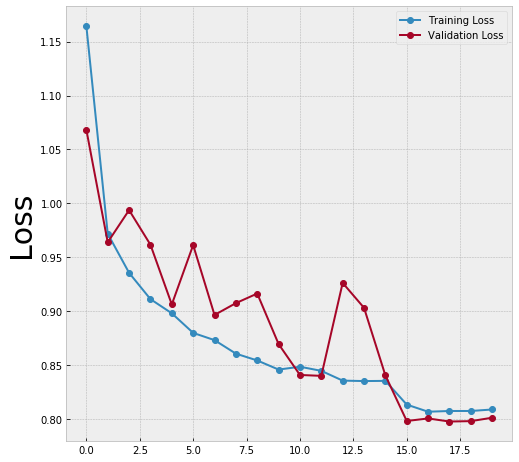

In [0]:
plt.figure(figsize=(8,8))
plt.plot(train_loss_list,  marker='o', label="Training Loss")
plt.plot(valid_loss_list,  marker='o', label="Validation Loss")
plt.ylabel('Loss', fontsize=30)
plt.legend()
plt.show()

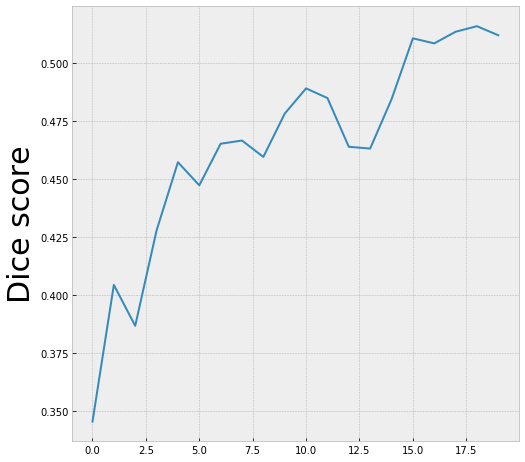

In [0]:
plt.figure(figsize=(8,8))
plt.plot(dice_score_list)
plt.ylabel('Dice score', fontsize=30)
plt.show()

## Compare Model Prediction with Target Mask

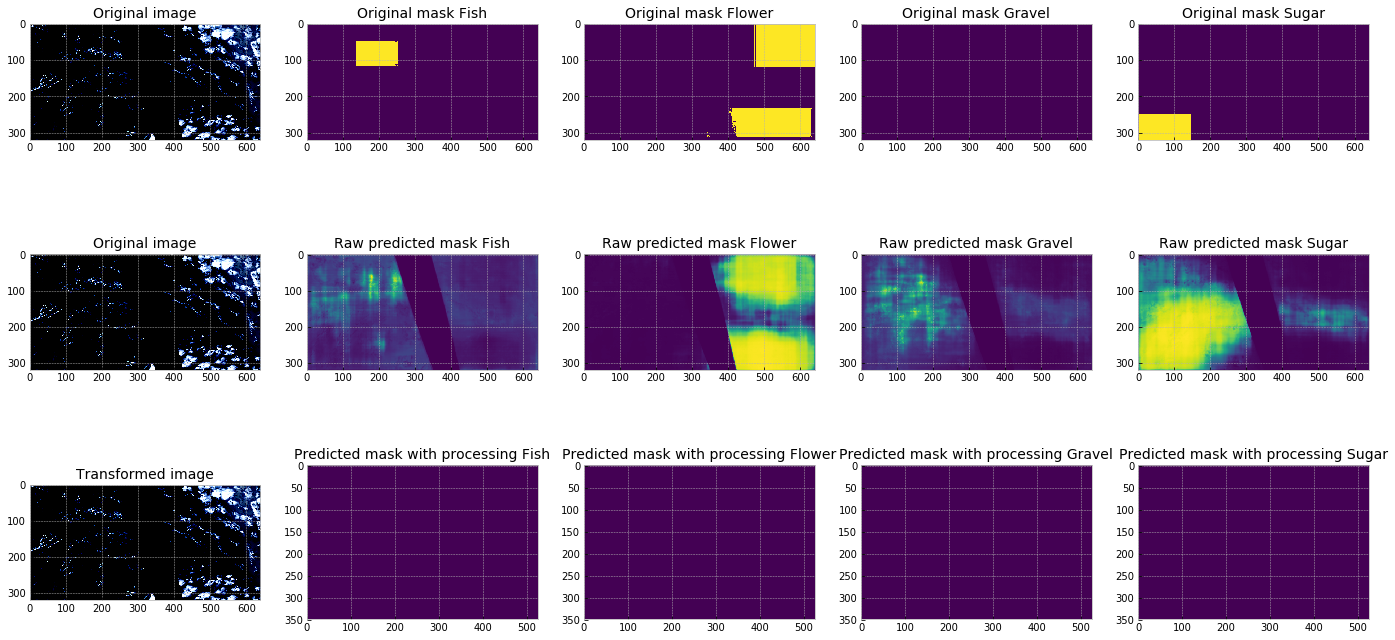

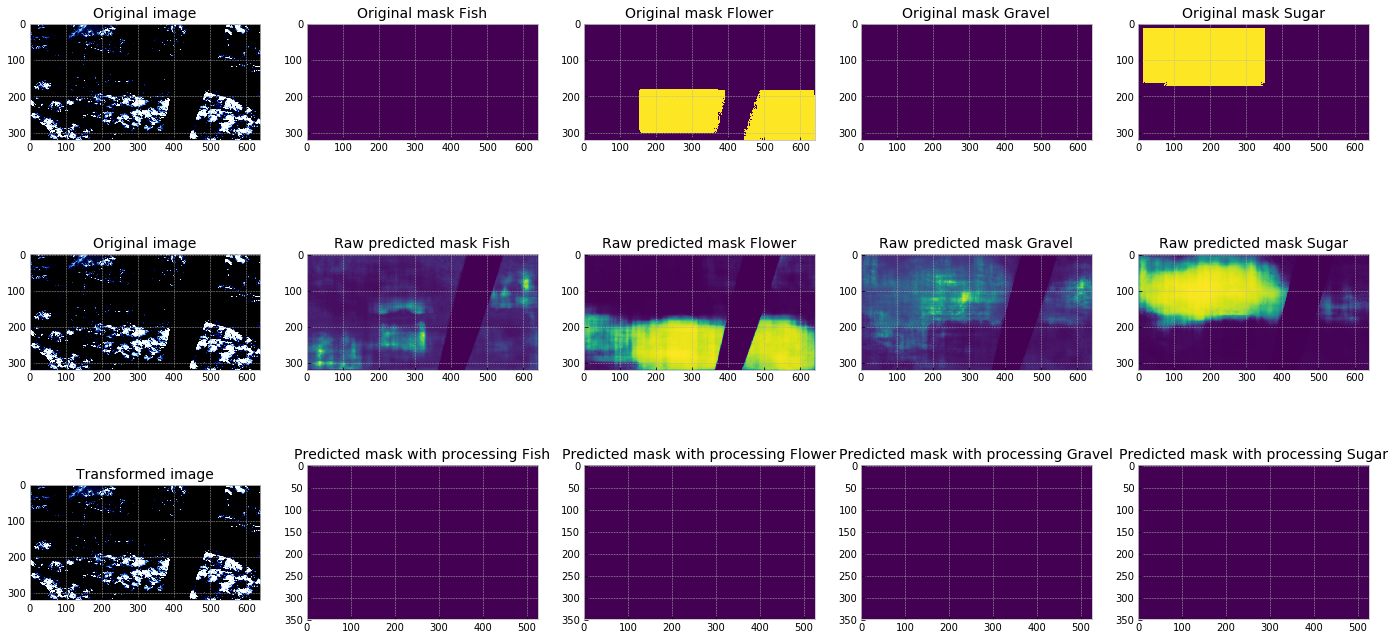

In [0]:
for i, (data, target) in enumerate(valid_loader):
    if i in range (10,12):
        if train_on_gpu:
            data = data.cuda()
        output = ((model(data))[0]).cpu().detach().numpy()
        image  = data[0].cpu().detach().numpy()
        mask   = target[0].cpu().detach().numpy()
        output = output.transpose(1 ,2, 0)
        image_vis = image.transpose(1, 2, 0)
        mask = mask.astype('uint8').transpose(1, 2, 0)
        pr_mask = np.zeros((350, 525, 4))
        visualize_with_raw(image=image_vis, mask=pr_mask,
                              original_image=image_vis, original_mask=mask,
                              raw_image=image_vis, raw_mask=output)
    else:
        continue
    if i >= 12:
        break
        
